A simple composite time-series forecasting model that repeatedly fits on residual values of the previous round, using different pooled averages of date-time features for prediction values in each round.  Final predictions are the combined predictions of all previous rounds.  As such, the difference in trend following the training phase will not be accomodated during prediction. 

I am grateful to my advisor, Dr. Bryan Bischof, who introduced this idea to me during an analytics practicum.  Here is a link to his presentation at ODSC West 2021, where the model is discussed within the larger context of composition in ml: https://www.youtube.com/watch?v=6s7sNydlFks  

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
def MAPE(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    try:
        mape = np.round(np.mean(np.abs((y - yhat) / y)) * 100, 2)
    except:
        print('Observed values are empty.')
        mape = np.nan
    return mape

The data was originally retrieved from ENTSO-E Transparency Platform, which provides access to electricity generation, transportation, and consumption data for the pan-European market.

I'm using German consumption data ranging from Jan 2015 to Jan 2020.  The German load data was initially obtained with 15-min resolution. It has been resampled it on an daily basis for this analysis.  The data was collated by Francois Raucent and posted on his Kaggle page linked below.  The initial data preparation also closely resembles the method used in his accompanying notebook.

https://www.kaggle.com/datasets/francoisraucent/western-europe-power-consumption?select=de.csv

In [2]:
start_date = pd.Timestamp("2015-01-01", tz="utc")
end_date = pd.Timestamp("2020-01-31", tz="utc")

In [3]:
url = 'https://raw.githubusercontent.com/brandonsalter/data/main/de.csv'
df = pd.read_csv(url)
df = df.drop(columns='end').set_index('start')
df.index = pd.to_datetime(df.index)
df.index.name = 'date'
df = df.groupby(pd.Grouper(freq='D')).mean()
df = df.loc[
    (df.index >= start_date) & (df.index <= end_date), :
]
df = df.reset_index()
df['date'] = pd.to_datetime(df['date']).dt.date
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1857 entries, 0 to 1856
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1857 non-null   object 
 1   load    1857 non-null   float64
dtypes: float64(1), object(1)
memory usage: 29.1+ KB


In [4]:
df

,date,load
0,2015-01-01,45354.583333
1,2015-01-02,51941.125000
2,2015-01-03,46564.729167
3,2015-01-04,45082.500000
4,2015-01-05,55246.697917
...,...,...
1852,2020-01-27,63640.906250
1853,2020-01-28,65516.406250
1854,2020-01-29,65814.312500
1855,2020-01-30,65415.531250


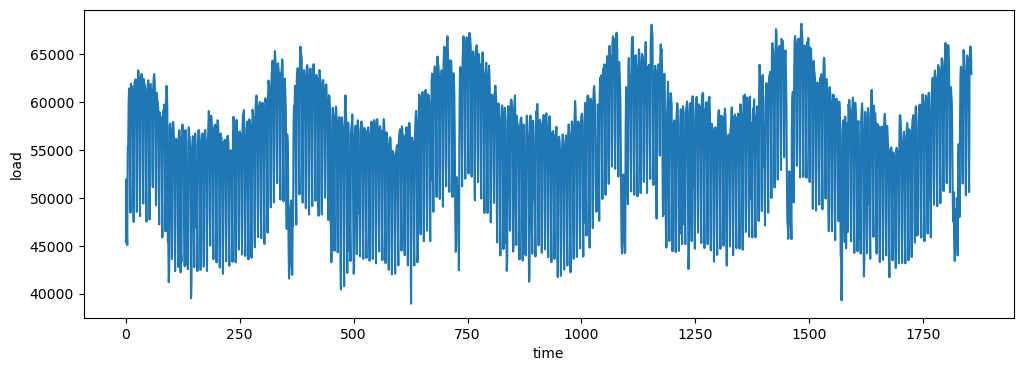

In [5]:
# TS Plot
ax = df['load'].plot(figsize=(12, 4),xlabel='time',ylabel='load')

In [6]:
# Descriptive Stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
load,1857.0,55917.7201,6531.667149,38952.65625,50627.84375,57270.8125,60713.354167,68183.5625


In [7]:
def append_datetime_cols(ts_df:pd.DataFrame, datetime_col:str, dt_format:str='%Y-%m-%d')-> pd.DataFrame:
    '''
    Extracts datetime components from specified datetime column of a dataframe.
    
    Appends year, month, week, day, week-of-year, week-of-month, and day-of-week to dataframe and returns a new copy.
    
    :ts_df: Dataframe w/ at least a datetime colume
    :datetime_col: Specified column containing datetime in dt_format string format
    :dt_format: String format for datetime_col
    '''
    t_df = ts_df.copy()
    
    dt_col = pd.to_datetime(df[datetime_col],
                           format = dt_format,
                           errors = 'coerce')
    
    t_df[datetime_col] = dt_col
    t_df['Year'], t_df['Month'], t_df['Day'] = dt_col.dt.year, dt_col.dt.month, dt_col.dt.day
    t_df['WeekOfYear'] = dt_col.dt.weekofyear
    t_df['WeekOfMonth'] = dt_col.apply(lambda d: (d.day-1) // 7 + 1)
    t_df['DayOfWeek'] = dt_col.dt.dayofweek.apply(lambda d: d+1)
    
    return t_df

In [8]:
dates_df = append_datetime_cols(df, 'date')
dates_df

,date,load,Year,Month,Day,WeekOfYear,WeekOfMonth,DayOfWeek
0,2015-01-01,45354.583333,2015,1,1,1,1,4
1,2015-01-02,51941.125000,2015,1,2,1,1,5
2,2015-01-03,46564.729167,2015,1,3,1,1,6
3,2015-01-04,45082.500000,2015,1,4,1,1,7
4,2015-01-05,55246.697917,2015,1,5,2,1,1
...,...,...,...,...,...,...,...,...
1852,2020-01-27,63640.906250,2020,1,27,5,4,1
1853,2020-01-28,65516.406250,2020,1,28,5,4,2
1854,2020-01-29,65814.312500,2020,1,29,5,5,3
1855,2020-01-30,65415.531250,2020,1,30,5,5,4


In [9]:
# Train-Test Split

label = 'load'

X = dates_df.loc[:, dates_df.columns != label]
y = dates_df[[label]]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    random_state = 42, 
                                                    shuffle = False)

In [10]:
print(f'Dataset Sizes: \nX_train: {len(X_train)} \nX_test: {len(X_test)} \ny_train: {len(y_train)} \ny_test: {len(y_test)}')

Dataset Sizes: 
X_train: 1244 
X_test: 613 
y_train: 1244 
y_test: 613


In [11]:
# Add label to training and test sets
train = X_train
train['load'] = y_train.to_numpy()

test = X_test
test['load'] = y_test.to_numpy()

train

,date,Year,Month,Day,WeekOfYear,WeekOfMonth,DayOfWeek,load
0,2015-01-01,2015,1,1,1,1,4,45354.583333
1,2015-01-02,2015,1,2,1,1,5,51941.125000
2,2015-01-03,2015,1,3,1,1,6,46564.729167
3,2015-01-04,2015,1,4,1,1,7,45082.500000
4,2015-01-05,2015,1,5,2,1,1,55246.697917
...,...,...,...,...,...,...,...,...
1239,2018-05-24,2018,5,24,21,4,4,59904.666667
1240,2018-05-25,2018,5,25,21,4,5,58483.343750
1241,2018-05-26,2018,5,26,21,4,6,49610.729167
1242,2018-05-27,2018,5,27,21,4,7,45490.864583


In [12]:
test

,date,Year,Month,Day,WeekOfYear,WeekOfMonth,DayOfWeek,load
1244,2018-05-29,2018,5,29,22,5,2,60612.083333
1245,2018-05-30,2018,5,30,22,5,3,59156.208333
1246,2018-05-31,2018,5,31,22,5,4,51165.458333
1247,2018-06-01,2018,6,1,22,1,5,54735.260417
1248,2018-06-02,2018,6,2,22,1,6,48264.947917
...,...,...,...,...,...,...,...,...
1852,2020-01-27,2020,1,27,5,4,1,63640.906250
1853,2020-01-28,2020,1,28,5,4,2,65516.406250
1854,2020-01-29,2020,1,29,5,5,3,65814.312500
1855,2020-01-30,2020,1,30,5,5,4,65415.531250


# Ensemble Baseline

In [13]:
def avg_pooling_by_col_compute_resids(ts_df: pd.DataFrame,
                                     pooling_col: str,
                                     feature_col: str,
                                     pred_col: str,
                                     resids_col: str) -> (pd.DataFrame, dict):
    '''
    Perform average pooling on a feature column and append the residual difference from the feature
    
    :ts_df: Input dataframe containing a pooling column and a feature column to pool
    :pooling_col: Column used to group by
    :feature_col: Column whose values are pooled (averaged) 
    :pred_col: Column to store predictions
    :resids_col: Target column for the residuals (avg pooling minus feature column) 
    '''
    training_df = ts_df.copy()
    pooled_values = list(training_df.groupby(pooling_col)[feature_col].mean())
    pooled_model_hash = {i+1:m for i,m in enumerate(pooled_values)}
    
    pooled_features_training_df = training_df[pooling_col].replace(pooled_model_hash)
    training_df[resids_col] = training_df[feature_col] - pooled_features_training_df
    training_df[pred_col] = pooled_features_training_df
    
    return training_df, pooled_model_hash

1. Average pooling by MOY on load (MOY Pooled) --> compute MOY Residual
2. Average pooling by WOM on MOY Residual (WOM_integrated_MOY Pooled) --> compute WOM Residual  
3. Average pooling by DOW on WOM Residual (DOW_integrated_WOM_integrated_MOY Pooled) --> compute DOW Residual    
4. Final Prediction = (MOY_pooled) + (WOM_integrated_MOY Pooled) + (DOW_integrated_WOM_integrated_MOY Pooled)

In [14]:
moy_df, moy_hash = avg_pooling_by_col_compute_resids(train,
                                                    'Month',
                                                    'load',
                                                    'moy_pooled',
                                                    'moy-actuals__resids'
                                                    )
wom_moy_df, wom_moy_hash = avg_pooling_by_col_compute_resids(moy_df,
                                                            'WeekOfMonth',
                                                            'moy-actuals__resids',
                                                            'wom_intgrtd_moy_pooled',
                                                            'wom-moy__resids_x2'
                                                            )
model, dow_wom_moy_hash = avg_pooling_by_col_compute_resids(wom_moy_df,
                                                           'DayOfWeek',
                                                           'wom-moy__resids_x2',
                                                           'dow_intgrtd_wom_intgrtd_moy_pooled',
                                                           'dow-wom_moy__resids_x3'
                                                           )
model['wom moy intgrtd baseline'] = model['moy_pooled'] + model['wom_intgrtd_moy_pooled']
model['dow wom moy intgrtd baseline'] = model['wom moy intgrtd baseline'] + model['dow_intgrtd_wom_intgrtd_moy_pooled']
model

,date,Year,Month,Day,WeekOfYear,WeekOfMonth,DayOfWeek,load,moy-actuals__resids,moy_pooled,wom-moy__resids_x2,wom_intgrtd_moy_pooled,dow-wom_moy__resids_x3,dow_intgrtd_wom_intgrtd_moy_pooled,wom moy intgrtd baseline,dow wom moy intgrtd baseline
0,2015-01-01,2015,1,1,1,1,4,45354.583333,-13577.459998,58932.043331,-13128.154429,-449.305569,-16696.374569,3568.220140,58482.737762,62050.957903
1,2015-01-02,2015,1,2,1,1,5,51941.125000,-6990.918331,58932.043331,-6541.612762,-449.305569,-8857.497153,2315.884391,58482.737762,60798.622153
2,2015-01-03,2015,1,3,1,1,6,46564.729167,-12367.314164,58932.043331,-11918.008596,-449.305569,-6006.697564,-5911.311032,58482.737762,52571.426730
3,2015-01-04,2015,1,4,1,1,7,45082.500000,-13849.543331,58932.043331,-13400.237762,-449.305569,-3621.470488,-9778.767274,58482.737762,48703.970488
4,2015-01-05,2015,1,5,2,1,1,55246.697917,-3685.345414,58932.043331,-3236.039846,-449.305569,-5148.356207,1912.316361,58482.737762,60395.054124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,2018-05-24,2018,5,24,21,4,4,59904.666667,7366.524621,52538.142045,7676.356431,-309.831810,4108.136291,3568.220140,52228.310235,55796.530376
1240,2018-05-25,2018,5,25,21,4,5,58483.343750,5945.201705,52538.142045,6255.033515,-309.831810,3939.149124,2315.884391,52228.310235,54544.194626
1241,2018-05-26,2018,5,26,21,4,6,49610.729167,-2927.412879,52538.142045,-2617.581069,-309.831810,3293.729963,-5911.311032,52228.310235,46316.999203
1242,2018-05-27,2018,5,27,21,4,7,45490.864583,-7047.277462,52538.142045,-6737.445652,-309.831810,3041.321622,-9778.767274,52228.310235,42449.542961


# Training Performance

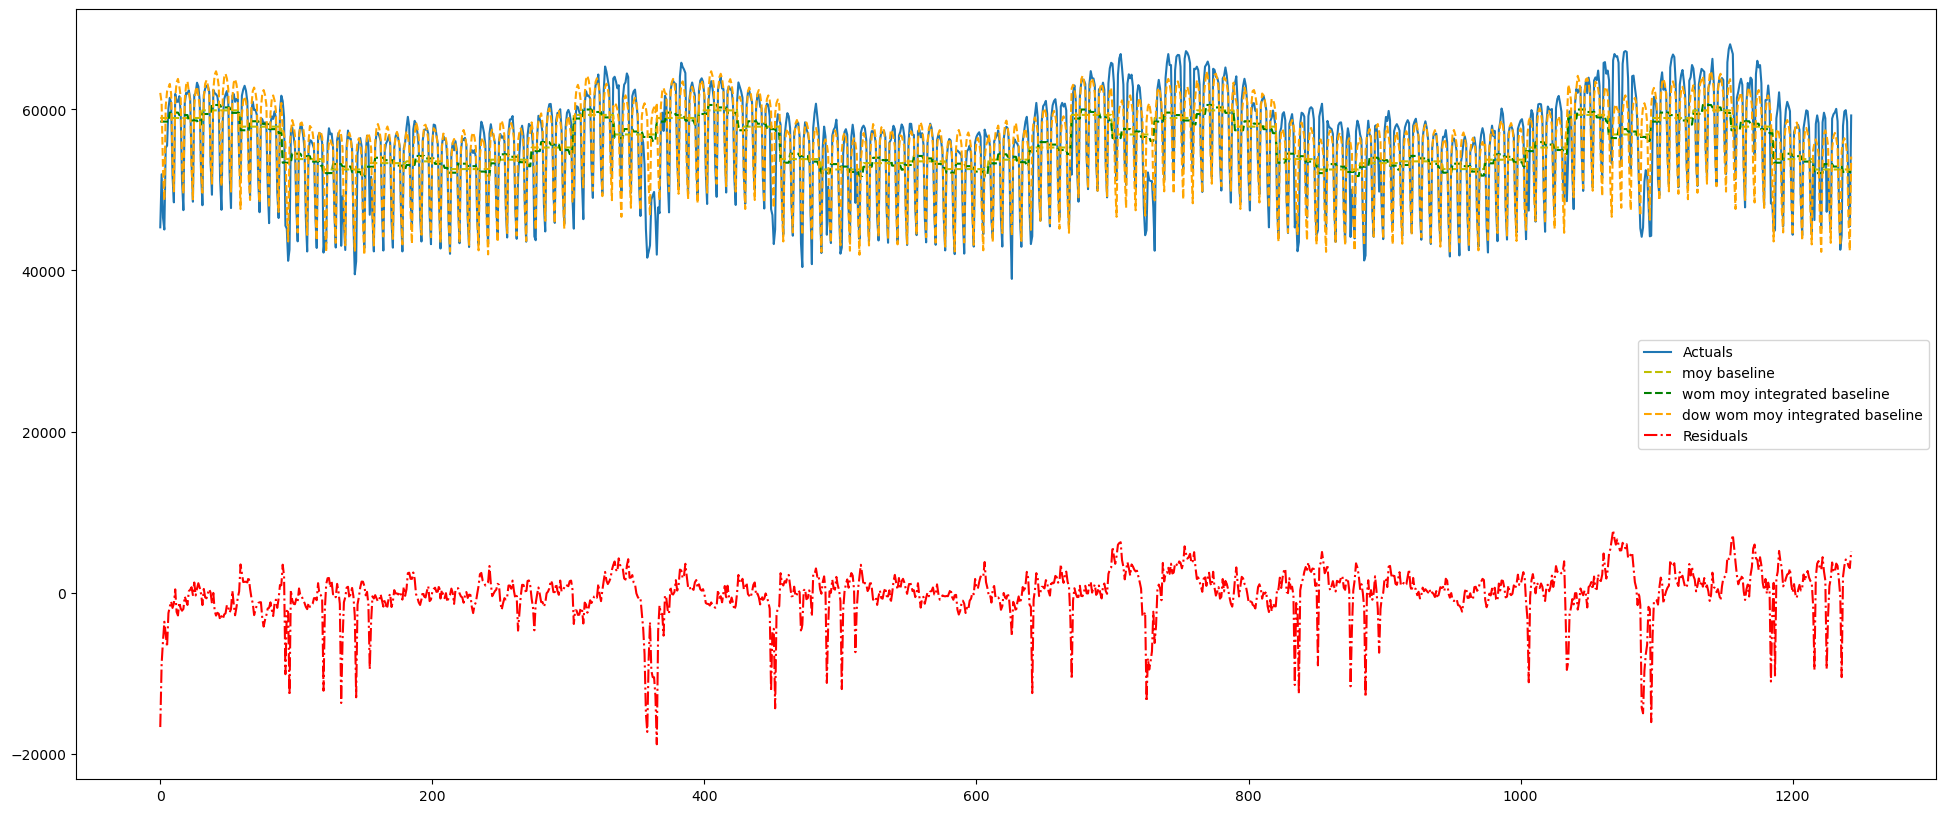

In [15]:
plt.figure(figsize=(24,10))
plt.plot(model['load'], 
         label='Actuals', 
         linestyle='-'
        )
plt.plot(model['moy_pooled'],
        label='moy baseline',
        linestyle='--',
        color='y'
        )
plt.plot(model['wom moy intgrtd baseline'],
        label='wom moy integrated baseline',
        linestyle='--',
        color='g'
        )
plt.plot(model['dow wom moy intgrtd baseline'],
        label='dow wom moy integrated baseline',
        linestyle='--',
        color='orange'
        )

plt.plot(model['dow-wom_moy__resids_x3'],
        label='Residuals',
        linestyle='-.',
        color='r'
        )

plt.legend()
plt.show()

In [16]:
model['dow-wom_moy__resids_x3'].mean() # mean zero residuals

-6.024305741647049e-13

In [17]:
def compute_errors(actuals_df: pd.DataFrame,
                   actuals_col: str,
                   preds_df: pd.DataFrame,
                   preds_col: str,
                   model_name: str=None
                  ):
    '''
    Compute a dictionary of time-series error functions from two columns of a dataframe.
    '''
    errors_dict = {'mse': MSE(actuals_df[actuals_col], preds_df[preds_col]),
                   'rmse': round(np.sqrt(MSE(actuals_df[actuals_col], preds_df[preds_col])),3),
                   'mae': MAE(actuals_df[actuals_col], preds_df[preds_col]),
                   'mape': MAPE(actuals_df[actuals_col], preds_df[preds_col]),
                   'prediction length': len(preds_df)
                  }
    if model_name is not None:
        errors_dict.update({'model_name': model_name})
        
    return pd.DataFrame.from_dict(errors_dict,
                                  orient='index',
                                  columns = [preds_col]
                                 )

In [18]:
pd.concat([compute_errors(model, 'load', model, 'moy_pooled'),
           compute_errors(model, 'load', model, 'wom moy intgrtd baseline'),
           compute_errors(model, 'load', model, 'dow wom moy intgrtd baseline')], axis=1)

,moy_pooled,wom moy intgrtd baseline,dow wom moy intgrtd baseline
mse,3.567996e+07,3.542665e+07,9.135217e+06
rmse,5.973271e+03,5.952029e+03,3.022452e+03
mae,5.220665e+03,5.187134e+03,1.892435e+03
mape,9.930000e+00,9.860000e+00,3.540000e+00
prediction length,1.244000e+03,1.244000e+03,1.244000e+03


In [19]:
def apply_model_hash_to_series(ts_df: pd.DataFrame,
                               model_hash: dict,
                               feature_col: str,
                               pred_col: str
                              ) -> pd.Series:
    '''
    Apply a model hash to the feature column to produce the prediction column.
    
    :ts_df: Input dataframe containing 
    :model_hash: Dictionary containing (datetime_value, pooled_value) pairs; obtained by avg_pooling_by_col_compute_resids()
    :feature_col: Column whose values are pooled (averaged)
    :pred_col: Column to store predictions (using feature_col and model_hash)
    '''
    test_df = ts_df.copy()
    
    return test_df[feature_col].replace(model_hash)

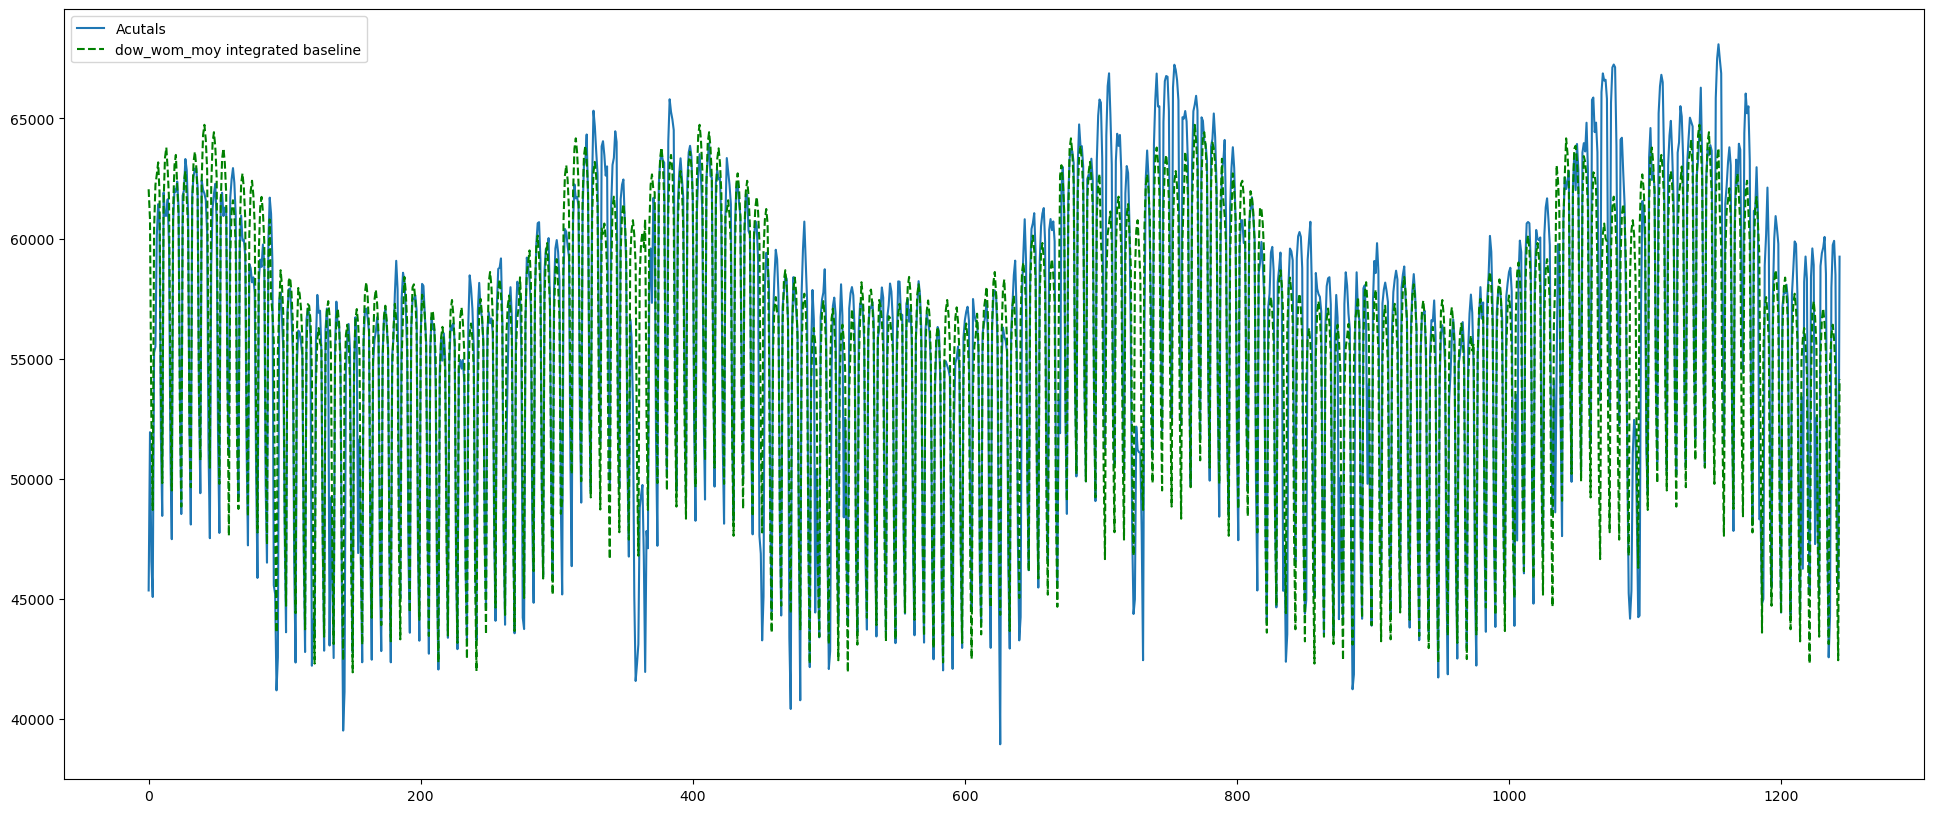

In [20]:
# Testing apply_model_hash_to_series(); should produce plot identical to the one above just w/o residuals

dow_wom_moy_preds = (apply_model_hash_to_series(train, moy_hash, 'Month', 'moy_preds') +
                     apply_model_hash_to_series(train, wom_moy_hash, 'WeekOfMonth', 'wom_moy_preds') +
                     apply_model_hash_to_series(train, dow_wom_moy_hash, 'DayOfWeek', 'dow_wom_moy_preds')
                    )
plt.figure(figsize=(24,10))
plt.plot(train['load'], label='Acutals', 
         linestyle='-'
        )
plt.plot(dow_wom_moy_preds,
         label='dow_wom_moy integrated baseline',
         linestyle='--',
         color='g'
        )
plt.legend()
plt.show()

# Plotting Performance Over Test Set

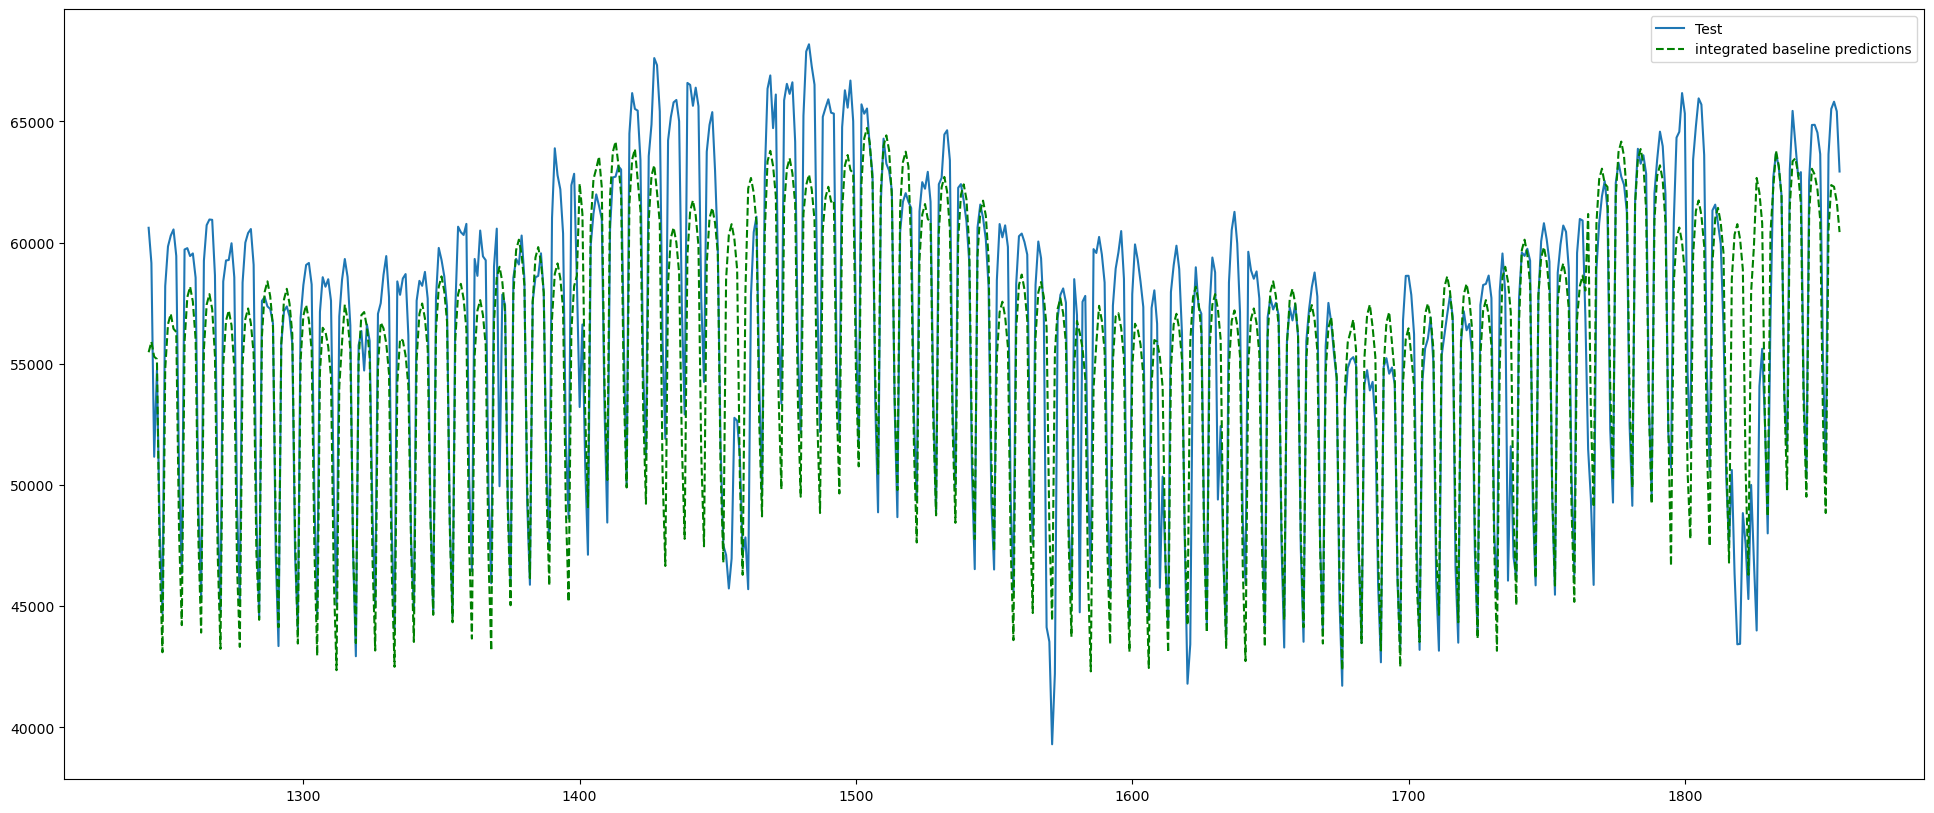

In [21]:
test_eval_df = test.copy()
test_eval_df['moy_preds'] = (apply_model_hash_to_series(test, moy_hash, 'Month', 'moy_preds')
                            )
test_eval_df['wom_moy_preds'] = (apply_model_hash_to_series(test, moy_hash, 'Month', 'moy_preds') +
                                 apply_model_hash_to_series(test, wom_moy_hash, 'WeekOfMonth', 'wom_moy_preds')
                                )
test_eval_df['dow_wom_moy_preds'] = (apply_model_hash_to_series(test, moy_hash, 'Month', 'moy_preds') +
                                     apply_model_hash_to_series(test, wom_moy_hash, 'WeekOfMonth', 'wom_moy_preds') +
                                     apply_model_hash_to_series(test, dow_wom_moy_hash, 'DayOfWeek', 'dow_wom_moy_preds')
                                    )
plt.figure(figsize=(24,10))
plt.plot(test['load'], label='Test', 
         linestyle='-'
        )
plt.plot(test_eval_df['dow_wom_moy_preds'],
         label='integrated baseline predictions',
         linestyle='--',
         color='g'
        )
plt.legend()
plt.show()

# Test Set Performance w/ Residuals

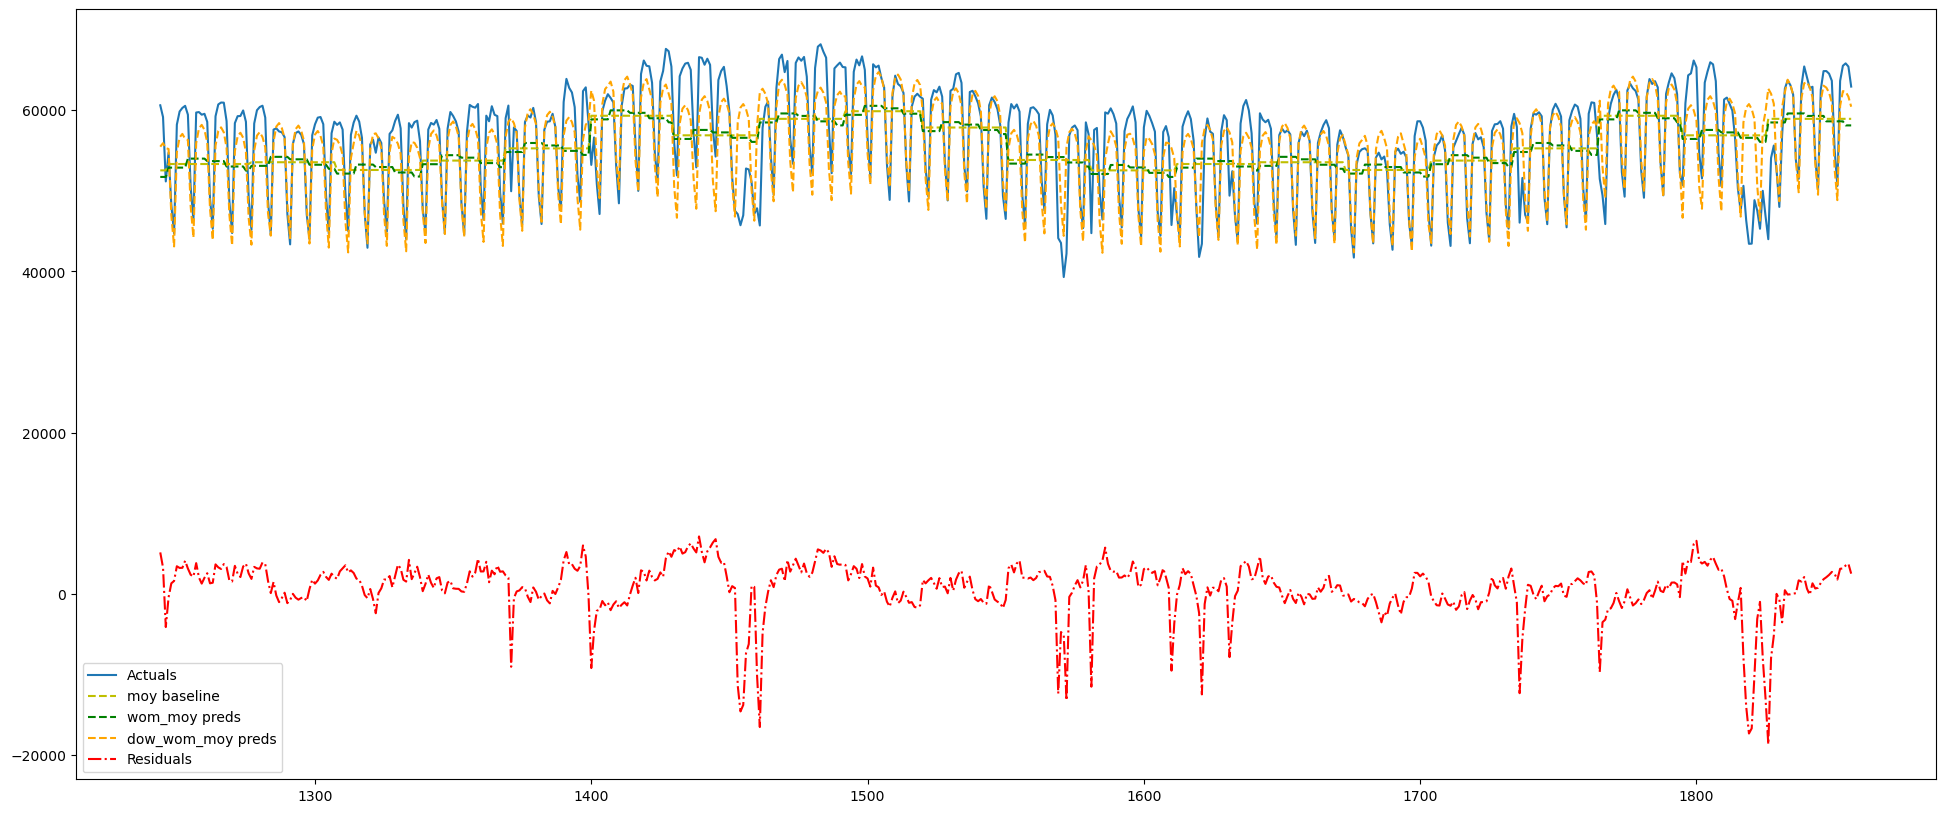

In [22]:
plt.figure(figsize=(24,10))
plt.plot(test_eval_df['load'], 
         label='Actuals', 
         linestyle='-'
        )
plt.plot(test_eval_df['moy_preds'],
        label='moy baseline',
        linestyle='--',
        color='y'
        )
plt.plot(test_eval_df['wom_moy_preds'],
        label='wom_moy preds',
        linestyle='--',
        color='g'
        )
plt.plot(test_eval_df['dow_wom_moy_preds'],
        label='dow_wom_moy preds',
        linestyle='--',
        color='orange'
        )

plt.plot(test_eval_df['load'] - test_eval_df['dow_wom_moy_preds'],
        label='Residuals',
        linestyle='-.',
        color='r'
        )

plt.legend()
plt.show()

In [23]:
resids = test_eval_df['load'] - test_eval_df['dow_wom_moy_preds']
resids.mean()

722.9884071296667

# A single loop model construction and eval

In [24]:
def construct_dow_wom_moy_models(
  training_df: pd.DataFrame, 
  actuals_column: str, 
  test_df: pd.DataFrame,
  custom_model_name: str=None,
  plot: bool=True,
  return_err: bool=True,
  return_preds: bool=True
):
  model_name = 'dom_wom_moy_preds' if custom_model_name is None else custom_model_name
  
  moy_df, moy_hash = avg_pooling_by_col_compute_resids(
    training_df, 
    'Month', 
    actuals_column, 
    'moy_pooled',
    'moy-actuals__resids'
  )
  wom_moy_df, wom_moy_hash = avg_pooling_by_col_compute_resids(
    moy_df, 
    'WeekOfMonth', 
    'moy-actuals__resids', 
    'wom_intgrtd_moy_pooled',
    'wom-moy__resids_x2'
  )
  _, dow_wom_moy_hash = avg_pooling_by_col_compute_resids(
    wom_moy_df, 
    'DayOfWeek', 
    'wom-moy__resids_x2', 
    'dow_intgrtd_wom_intgrtd_moy_pooled',
    'dow-wom_moy__resids_x3'
  )
  
  test_eval_df = test_df.copy()
  test_eval_df[model_name] = (
    apply_model_hash_to_series(test_eval_df, moy_hash, 'Month', 'moy_preds') + 
    apply_model_hash_to_series(test_eval_df, wom_moy_hash, 'WeekOfMonth', 'wom_moy_preds') + 
    apply_model_hash_to_series(test_eval_df, dow_wom_moy_hash, 'DayOfWeek', 'dow_wom_moy_preds')
  )
  
  if plot:
    plt.figure(figsize=(24,10))
    plt.plot(test_eval_df['load'], label= 'Actuals', linestyle='-')
    plt.plot(
      test_eval_df[model_name], 
      label= 'dow_wom_moy integrated basline', 
      linestyle='--', 
      color='y'
    )
    plt.plot(
      test_eval_df['load'] - test_eval_df[model_name], 
      label= 'Resids', 
      linestyle='-.', 
      color='r'
    )

    plt.legend()
    plt.show()
    
  return_data = {'model_name': model_name}
  
  if return_err:
    return_data.update(
      {'errors': compute_errors(test_eval_df, 'load', test_eval_df, model_name)}
    )
    
  if return_preds:
    return_data.update(
      {'predictions': test_eval_df[model_name]}
    )
    
  return return_data

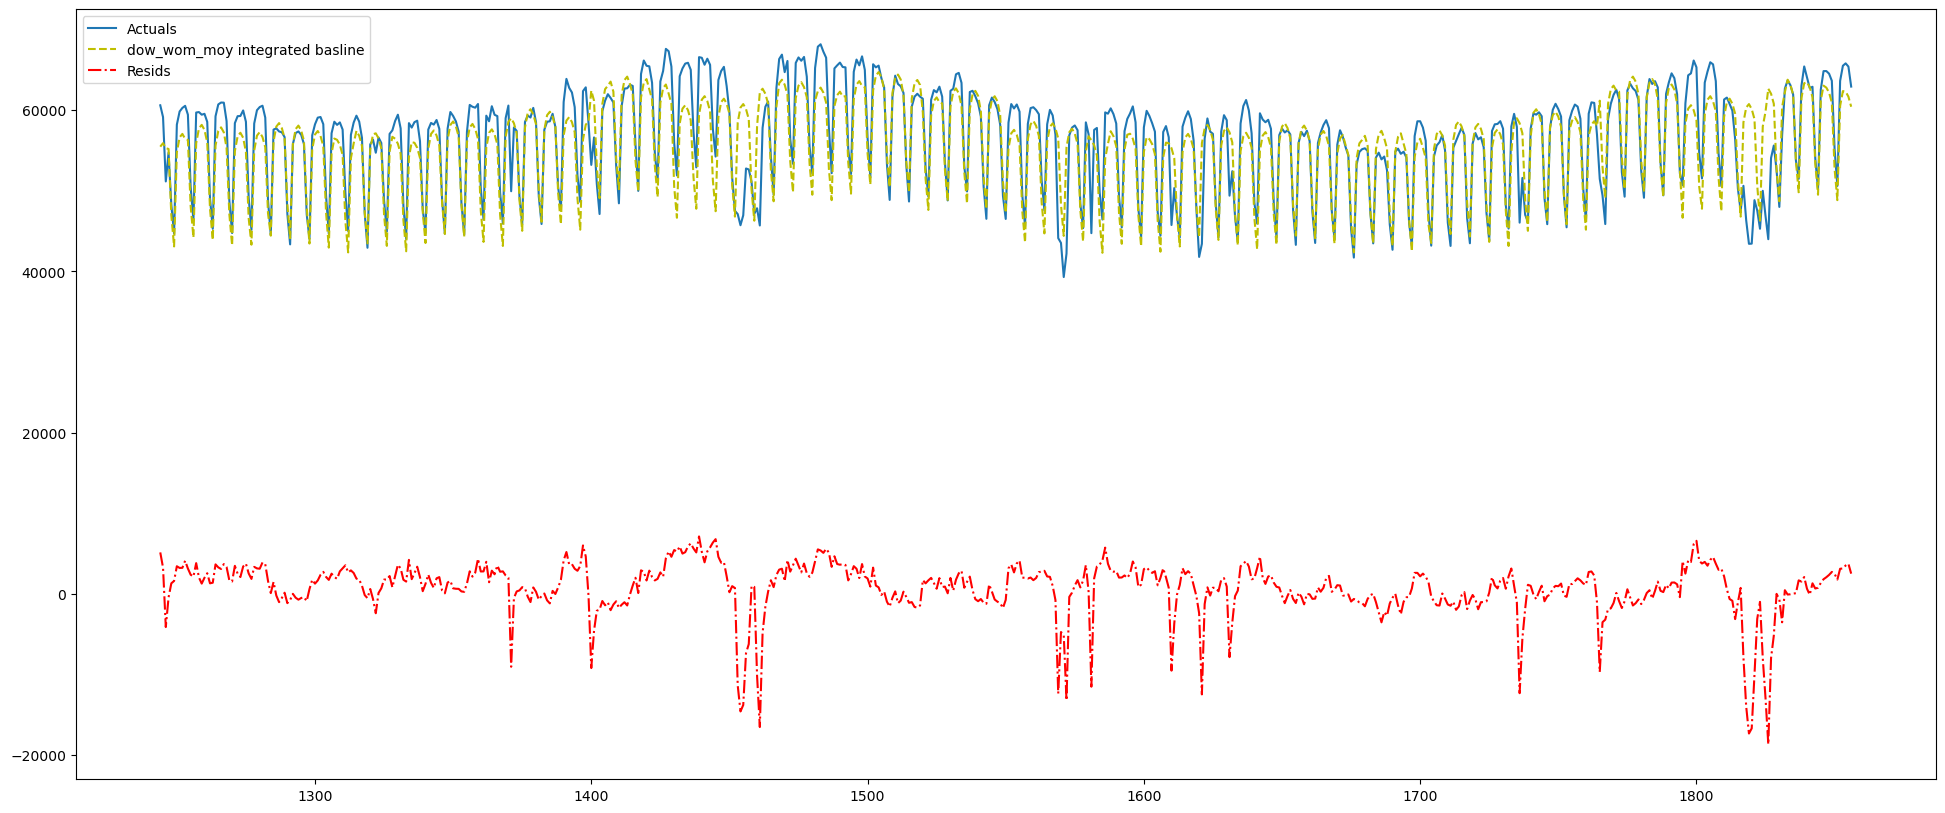

,mse,rmse,mae,mape,prediction length
dom_wom_moy_preds,1.183461e+07,3440.147,2363.361774,4.31,613.0


In [25]:
construct_dow_wom_moy_models(
  dates_df[0:int(len(dates_df)*.67)], 
  'load', 
  dates_df[int(len(dates_df)*.67):], 
  return_err=True
)['errors'].T

In [26]:
err_list = []
preds_list = []
model_list = []
forecast_window_length = 14
for i in list(reversed(range(10, int(len(dates_df)*0.33))))[:90]:
  train = dates_df[0:-i] 
  test = dates_df[-i:-i+forecast_window_length]
  pred_output = construct_dow_wom_moy_models(
    train, 
    'load', 
    test, 
    custom_model_name=f'd-w-m;i=-{i}',
    plot=False,
    return_err=True,
    return_preds=True,
  )
  model_list.append(
      pred_output['model_name']
  )
  err_list.append(
      pred_output['errors']
  )
  preds_list.append(
    pred_output['predictions']
  )
err_df = pd.concat(err_list, axis=1).T
err_df['model_names'] = model_list
display(err_df)
fcast_df = pd.concat([dates_df[int(len(dates_df)*0.67):]]+preds_list, axis=1)
display(fcast_df)

,mse,rmse,mae,mape,prediction length,model_names
d-w-m;i=-611,8.153133e+06,2855.369,2614.548927,4.70,14.0,d-w-m;i=-611
d-w-m;i=-610,7.080013e+06,2660.829,2446.830081,4.33,14.0,d-w-m;i=-610
d-w-m;i=-609,7.459496e+06,2731.208,2584.250385,4.56,14.0,d-w-m;i=-609
d-w-m;i=-608,7.739684e+06,2782.029,2636.754907,4.65,14.0,d-w-m;i=-608
d-w-m;i=-607,8.162257e+06,2856.966,2706.183797,4.77,14.0,d-w-m;i=-607
...,...,...,...,...,...,...
d-w-m;i=-526,3.900634e+06,1975.002,1761.668759,3.16,14.0,d-w-m;i=-526
d-w-m;i=-525,3.571183e+06,1889.757,1689.789106,3.04,14.0,d-w-m;i=-525
d-w-m;i=-524,3.532356e+06,1879.456,1645.549989,2.94,14.0,d-w-m;i=-524
d-w-m;i=-523,3.547749e+06,1883.547,1592.347256,2.81,14.0,d-w-m;i=-523


,date,load,Year,Month,Day,WeekOfYear,WeekOfMonth,DayOfWeek,d-w-m;i=-611,d-w-m;i=-610,...,d-w-m;i=-531,d-w-m;i=-530,d-w-m;i=-529,d-w-m;i=-528,d-w-m;i=-527,d-w-m;i=-526,d-w-m;i=-525,d-w-m;i=-524,d-w-m;i=-523,d-w-m;i=-522
1244,2018-05-29,60612.083333,2018,5,29,22,5,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1245,2018-05-30,59156.208333,2018,5,30,22,5,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1246,2018-05-31,51165.458333,2018,5,31,22,5,4,55553.532973,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1247,2018-06-01,54735.260417,2018,6,1,22,1,5,55169.757629,55171.545403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1248,2018-06-02,48264.947917,2018,6,2,22,1,6,46942.562206,46944.349981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,2020-01-27,63640.906250,2020,1,27,5,4,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853,2020-01-28,65516.406250,2020,1,28,5,4,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854,2020-01-29,65814.312500,2020,1,29,5,5,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855,2020-01-30,65415.531250,2020,1,30,5,5,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TS Error Metric Plots

<function matplotlib.pyplot.show(close=None, block=None)>

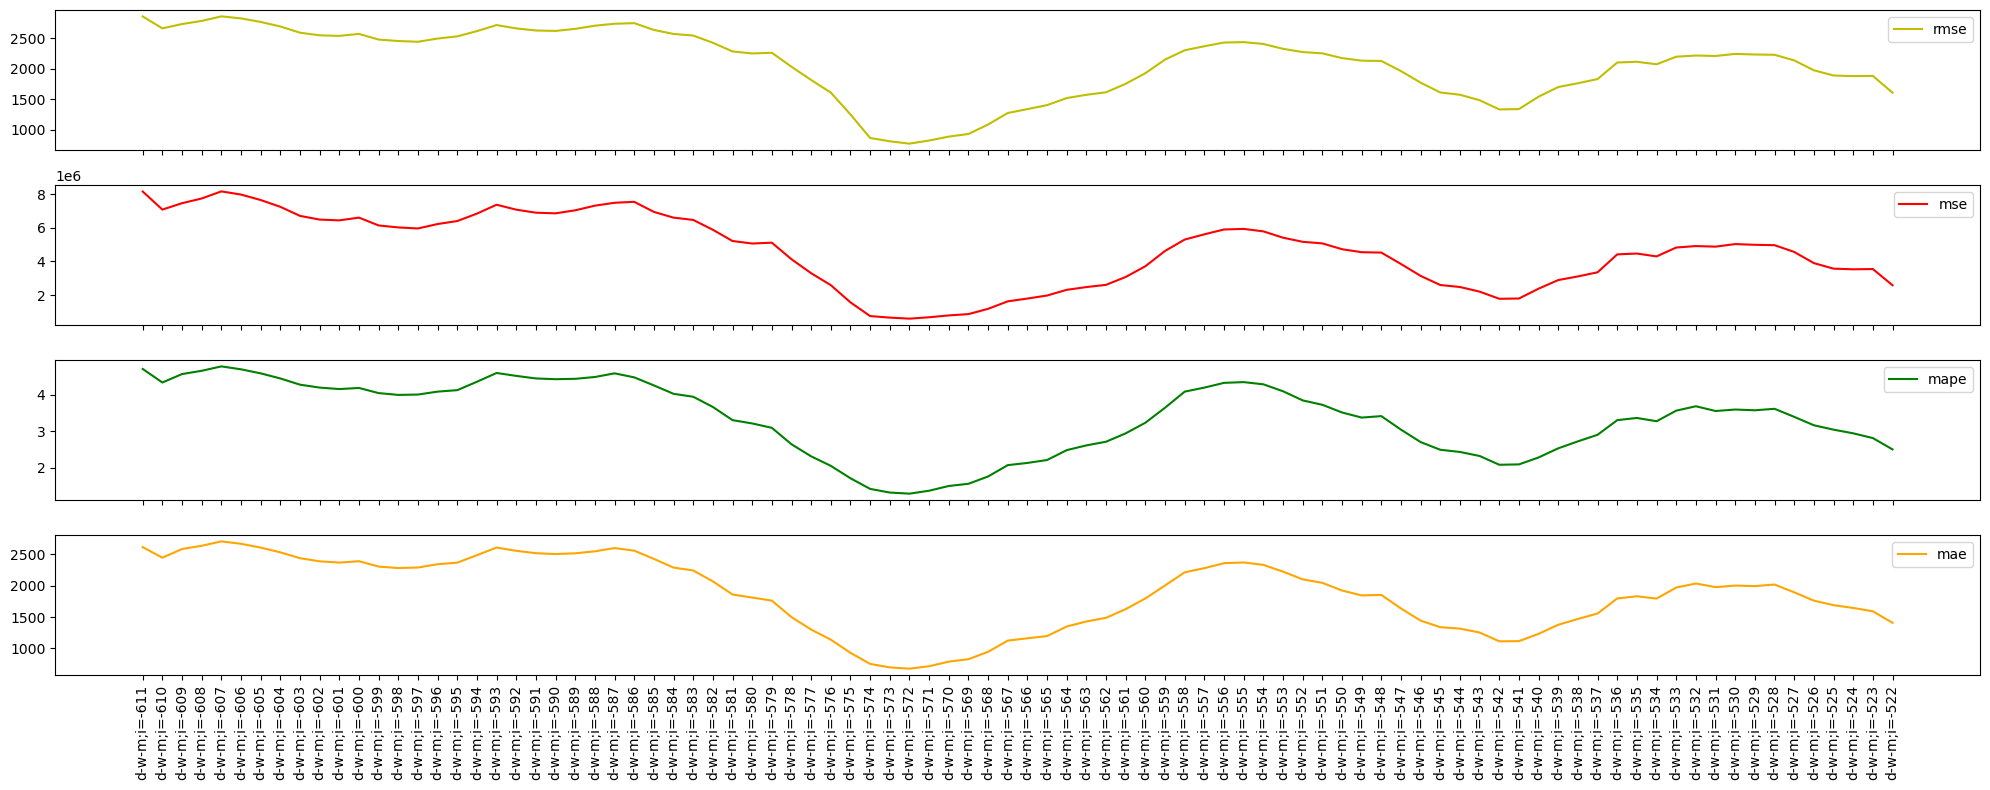

In [27]:
fig, axs = plt.subplots(4, 1, sharex = True, figsize = (20,8))
axs[0].plot(err_df['rmse'],
            label='rmse',
            linestyle='-',
            color='y'
           )
axs[1].plot(err_df['mse'],
            label='mse',
            linestyle='-',
            color='r'
           )
axs[2].plot(err_df['mape'],
            label='mape',
            linestyle='-',
            color='g'
           )
axs[3].plot(err_df['mae'],
            label='mae',
            linestyle='-',
            color='orange'
           )

axs[3].set_xticklabels(err_df['model_names'], rotation = 90)

fig.tight_layout()
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
plt.show